# Deep Q Network with Prioritized Experience Replay

## Imports

In [1]:
import gym
import numpy as np
import torch
import torch.optim as optim

from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

from timeit import default_timer as timer
from datetime import timedelta
import math

from utils.wrappers import *
from agents.DQN import Model as DQN_Agent
from networks.networks import DQN
from networks.network_bodies import AtariBody

from utils.hyperparameters import Config

## Hyperparameters

In [2]:
config = Config()

config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = config.device

#epsilon variables
config.epsilon_start = 1.0
config.epsilon_final = 0.01
config.epsilon_decay = 30000
config.epsilon_by_frame = lambda frame_idx: config.epsilon_final + (config.epsilon_start - config.epsilon_final) * math.exp(-1. * frame_idx / config.epsilon_decay)

#misc agent variables
config.GAMMA=0.99
config.LR=1e-4

#memory
config.TARGET_NET_UPDATE_FREQ = 1000
config.EXP_REPLAY_SIZE = 100000
config.BATCH_SIZE = 32
config.PRIORITY_ALPHA=0.6
config.PRIORITY_BETA_START=0.4
config.PRIORITY_BETA_FRAMES = 100000

#Learning control variables
config.LEARN_START = 10000
config.MAX_FRAMES=700000

#Nstep controls
config.N_STEPS=1

## Prioritized Replay (Without Rank-Based Priority)

In [3]:
class PrioritizedReplayMemory(object):  
    def __init__(self, capacity, alpha=0.6, beta_start=0.4, beta_frames=100000):
        self.prob_alpha = alpha
        self.capacity   = capacity
        self.buffer     = []
        self.pos        = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.frame = 1
        self.beta_start = beta_start
        self.beta_frames = beta_frames

    def beta_by_frame(self, frame_idx):
        return min(1.0, self.beta_start + frame_idx * (1.0 - self.beta_start) / self.beta_frames)
    
    def push(self, transition):
        max_prio = self.priorities.max() if self.buffer else 1.0**self.prob_alpha
        
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.pos] = transition
        
        self.priorities[self.pos] = max_prio

        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, batch_size):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]

        total = len(self.buffer)

        probs = prios / prios.sum()

        indices = np.random.choice(total, batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        
        beta = self.beta_by_frame(self.frame)
        self.frame+=1

        #min of ALL probs, not just sampled probs
        prob_min = probs.min()
        max_weight = (prob_min*total)**(-beta)

        weights  = (total * probs[indices]) ** (-beta)
        weights /= max_weight
        weights  = torch.tensor(weights, device=device, dtype=torch.float)
        
        return samples, indices, weights
    
    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = (prio + 1e-5)**self.prob_alpha

    def __len__(self):
        return len(self.buffer)

## Agent

In [4]:
class Model(DQN_Agent):
    def __init__(self, static_policy=False, env=None, config=None):
        super(Model, self).__init__(static_policy, env, config)
    
    def declare_networks(self):
        self.model = DQN(self.num_feats, self.num_actions, body=AtariBody)
        self.target_model = DQN(self.num_feats, self.num_actions, body=AtariBody)
    
    def declare_memory(self):
        self.memory = PrioritizedReplayMemory(self.experience_replay_size, self.priority_alpha, self.priority_beta_start, self.priority_beta_frames)
        
    def compute_loss(self, batch_vars):
        batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values, indices, weights = batch_vars

        #estimate
        self.model.sample_noise()
        current_q_values = self.model(batch_state).gather(1, batch_action)
        
        #target
        with torch.no_grad():
            max_next_q_values = torch.zeros(self.batch_size, device=self.device, dtype=torch.float).unsqueeze(dim=1)
            if not empty_next_state_values:
                max_next_action = self.get_max_next_state_action(non_final_next_states)
                self.target_model.sample_noise()
                max_next_q_values[non_final_mask] = self.target_model(non_final_next_states).gather(1, max_next_action)
            expected_q_values = batch_reward + ((self.gamma**self.nsteps)*max_next_q_values)

        diff = (expected_q_values - current_q_values)
        self.memory.update_priorities(indices, diff.detach().squeeze().abs().cpu().numpy().tolist())
        loss = self.huber(diff).squeeze() * weights
        loss = self.huber(diff)
    
        loss = loss.mean()

        return loss

## Plot Results

In [5]:
def plot(frame_idx, rewards, losses, sigma, elapsed_time):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s. time: %s' % (frame_idx, np.mean(rewards[-10:]), elapsed_time))
    plt.plot(rewards)
    if losses:
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
    if sigma:
        plt.subplot(133)
        plt.title('noisy param magnitude')
        plt.plot(sigma)
    plt.show()

## Training Loop

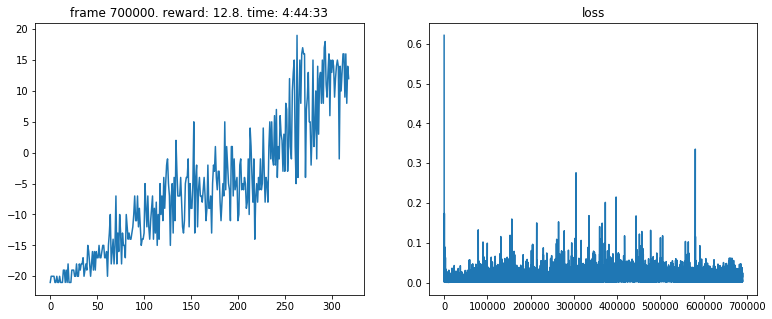

In [6]:
start=timer()

env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env, frame_stack=False)
env    = wrap_pytorch(env)
model = Model(env=env, config=config)

episode_reward = 0

observation = env.reset()
for frame_idx in range(1, config.MAX_FRAMES + 1):
    epsilon = config.epsilon_by_frame(frame_idx)

    action = model.get_action(observation, epsilon)
    prev_observation=observation
    observation, reward, done, _ = env.step(action)
    observation = None if done else observation

    model.update(prev_observation, action, reward, observation, frame_idx)
    episode_reward += reward

    if done:
        model.finish_nstep()
        model.reset_hx()
        observation = env.reset()
        model.save_reward(episode_reward)
        episode_reward = 0
        
        if np.mean(model.rewards[-10:]) > 19:
            plot(frame_idx, all_rewards, losses, timedelta(seconds=int(timer()-start)))
            break

    if frame_idx % 10000 == 0:
        plot(frame_idx, model.rewards, model.losses, model.sigma_parameter_mag, timedelta(seconds=int(timer()-start)))

model.save_w()
env.close()